In [299]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import tensorflow as tf

# 1. Data

In [300]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [301]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [302]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [303]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. Modeling
### Generator

In [304]:
num_input = 28 * 28
num_latent_variable = 100   # 잠재 변수 z의 차원
num_hidden = 128

def random_normal_intializer(stddev):
  return tf.keras.initializers.RandomNormal(mean=0.0, stddev=stddev, seed=None)

In [323]:

class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    self.main = model


  def call(self, x):
    return self.main(x)

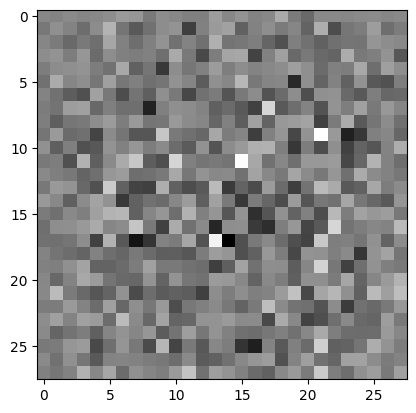

In [324]:
# 생성자(Generator) 모델을 선언합니다.
generator = Generator()


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

b=tf.reshape(generated_image, (28, 28))
plt.imshow(b, cmap='gray')

### Discriminator

In [325]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='tanh'))

    self.main = model

  def call(self, x):
    return self.main(x)

In [326]:
# 구분자(Discriminator) 모델을 선언합니다.
discriminator = Discriminator()

decision = discriminator(generated_image, training=False)
print (decision)

tf.Tensor([[-0.00091566]], shape=(1, 1), dtype=float32)


### Loss Function and Optimizers

In [327]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [328]:
# Generator의 손실 함수를 정의합니다.
@tf.function
def generator_loss(D_fake):
  return cross_entropy(tf.ones_like(D_fake), D_fake)        # log(D(G(z))

In [329]:
# Discriminator의 손실 함수를 정의합니다.
@tf.function
def discriminator_loss(D_real, D_fake):
  d_loss_real = cross_entropy(tf.ones_like(D_real), D_real)# log(D(x))
  d_loss_fake = cross_entropy(tf.zeros_like(D_fake), D_fake) # log(1-D(G(z)))
  d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

  return d_loss

In [330]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 3. Training

In [331]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [334]:
import matplotlib.gridspec as gridspec

def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  generations = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))
  gs = gridspec.GridSpec(4, 4)
  gs.update(wspace=0.05, hspace=0.05)

  for i, sample in enumerate(generations):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    sample = tf.reshape(sample* 127.5 + 127.5, [28, 28])
    plt.imshow(sample, cmap='gray')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [335]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot history
    plt.plot(d_hist, label='disc')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()

In [336]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


In [337]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

In [338]:
def train(dataset, epochs):
  d_hist, g_hist = [],[]
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      d_loss_print, g_loss_print = train_step(image_batch)
      d_hist.append(d_loss_print)
      g_hist.append(g_loss_print)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 1 == 0:
      print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (epoch, g_hist[-1], d_hist[-1]))
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 10==0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  plot_history(d_hist, g_hist)

반복(Epoch): 0, Generator 손실함수(g_loss): 0.494874, Discriminator 손실함수(d_loss): 1.504246
Time for epoch 1 is 20.467096090316772 sec


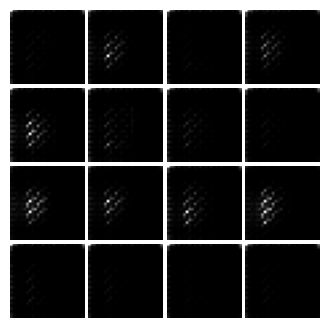

반복(Epoch): 1, Generator 손실함수(g_loss): 1.288849, Discriminator 손실함수(d_loss): 1.620672
Time for epoch 2 is 10.540581226348877 sec


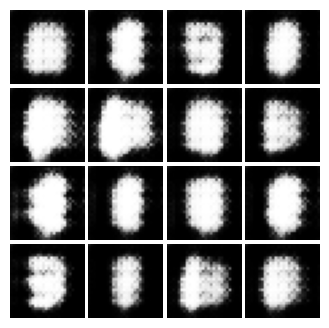

반복(Epoch): 2, Generator 손실함수(g_loss): 0.844191, Discriminator 손실함수(d_loss): 1.297768
Time for epoch 3 is 10.404888391494751 sec


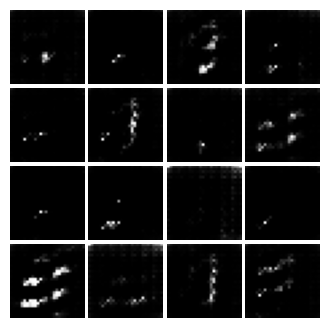

반복(Epoch): 3, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 4 is 10.2924063205719 sec


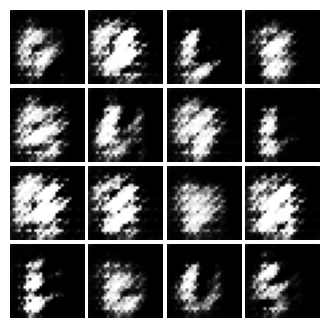

반복(Epoch): 4, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 5 is 10.179952621459961 sec


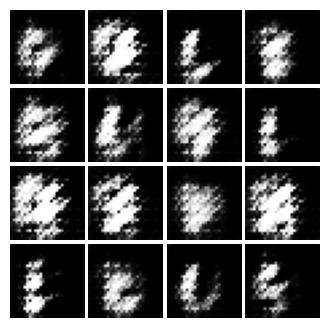

반복(Epoch): 5, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 6 is 10.160275936126709 sec


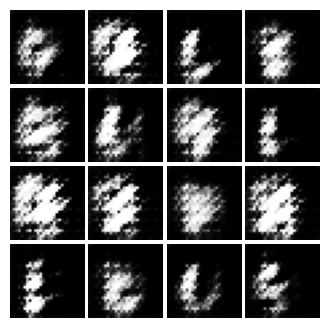

반복(Epoch): 6, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 7 is 10.171960830688477 sec


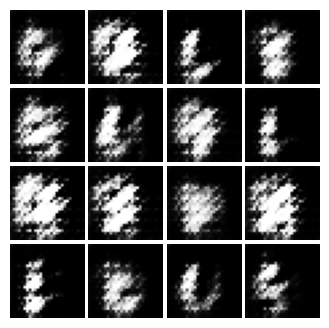

반복(Epoch): 7, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 8 is 10.211296081542969 sec


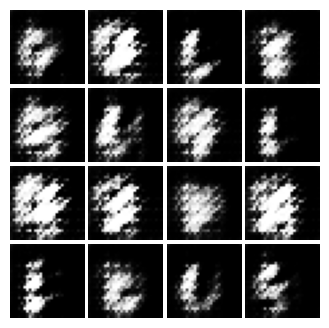

반복(Epoch): 8, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 9 is 10.231070280075073 sec


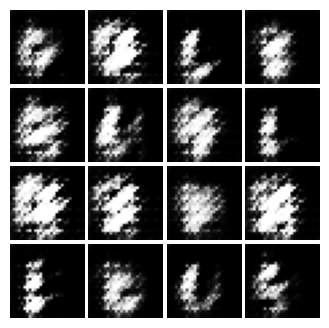

반복(Epoch): 9, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 10 is 10.232009172439575 sec


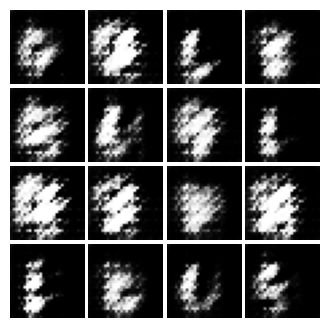

반복(Epoch): 10, Generator 손실함수(g_loss): 1.313258, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 11 is 10.21747350692749 sec


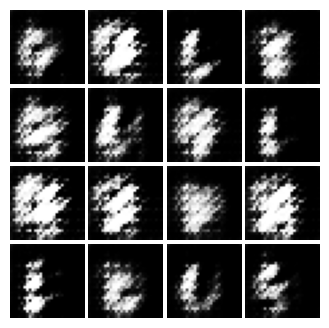

반복(Epoch): 11, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 12 is 10.227503061294556 sec


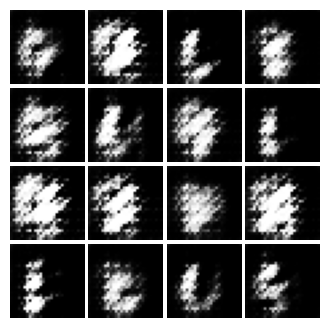

반복(Epoch): 12, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 13 is 10.19803524017334 sec


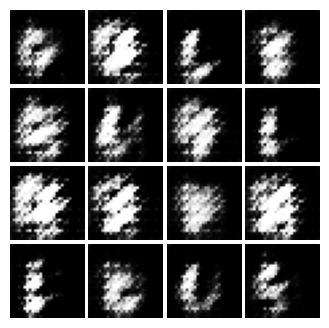

반복(Epoch): 13, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 14 is 10.187156915664673 sec


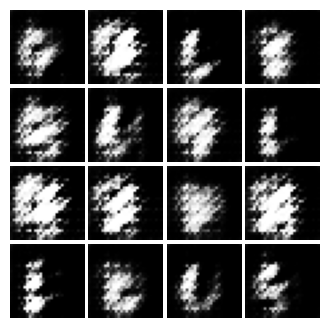

반복(Epoch): 14, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 15 is 10.1860933303833 sec


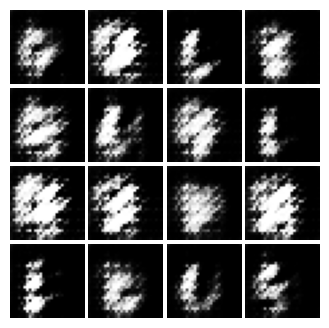

반복(Epoch): 15, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 16 is 10.185439586639404 sec


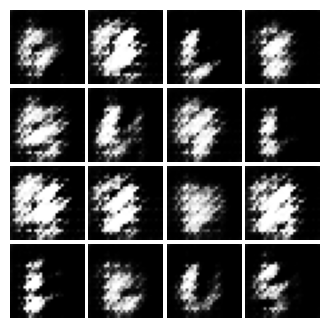

반복(Epoch): 16, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 17 is 10.209108591079712 sec


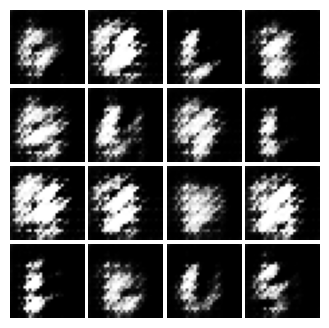

반복(Epoch): 17, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 18 is 10.22113823890686 sec


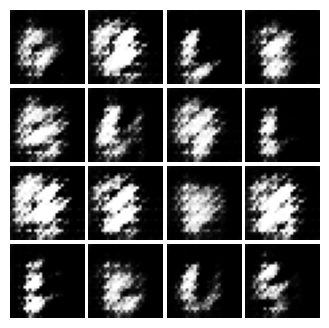

반복(Epoch): 18, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 19 is 10.219640731811523 sec


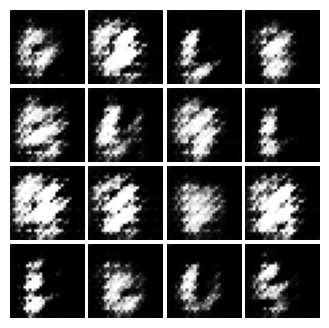

반복(Epoch): 19, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 20 is 10.221636056900024 sec


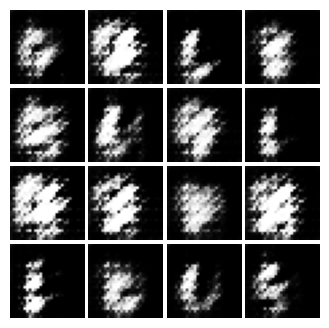

반복(Epoch): 20, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 21 is 10.184585332870483 sec


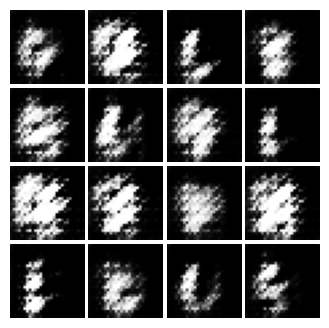

반복(Epoch): 21, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 22 is 10.185669183731079 sec


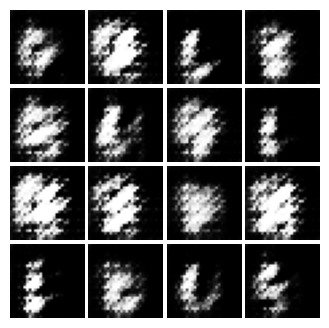

반복(Epoch): 22, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 23 is 10.202155590057373 sec


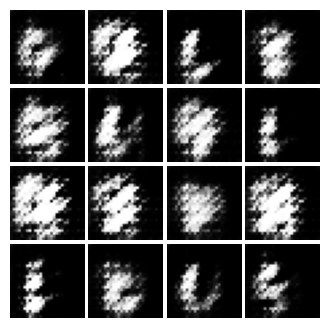

반복(Epoch): 23, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 24 is 10.187838077545166 sec


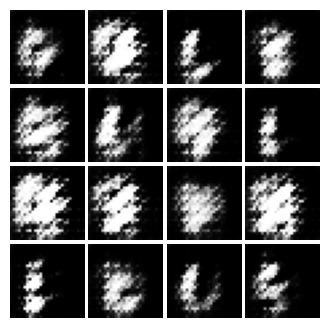

반복(Epoch): 24, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 25 is 10.207504510879517 sec


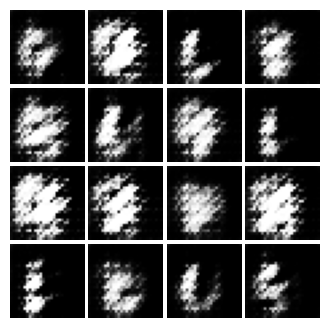

반복(Epoch): 25, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 26 is 10.23435115814209 sec


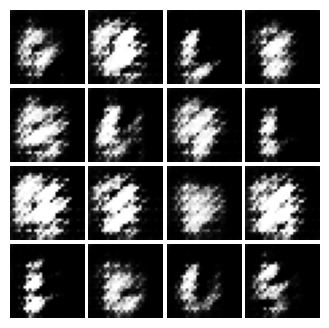

반복(Epoch): 26, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 27 is 10.185985803604126 sec


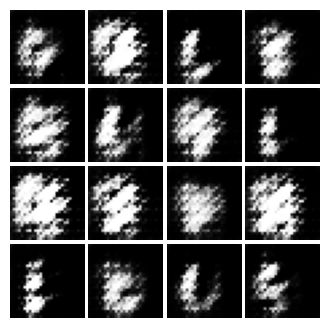

반복(Epoch): 27, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 28 is 10.167032480239868 sec


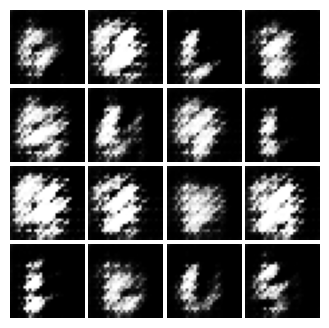

반복(Epoch): 28, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 29 is 10.137861967086792 sec


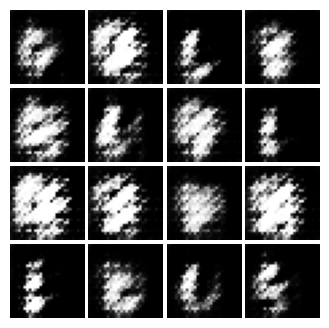

반복(Epoch): 29, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 30 is 10.131043910980225 sec


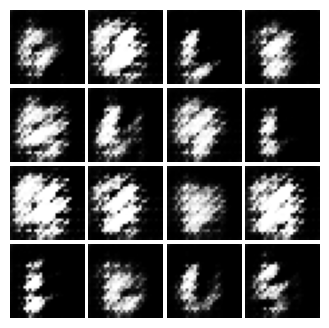

반복(Epoch): 30, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 31 is 10.125726699829102 sec


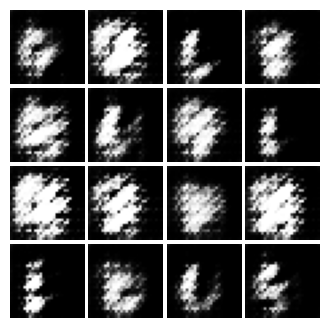

반복(Epoch): 31, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 32 is 10.105759382247925 sec


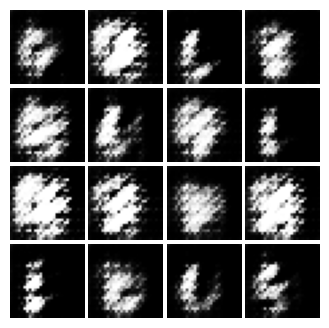

반복(Epoch): 32, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 33 is 10.124722480773926 sec


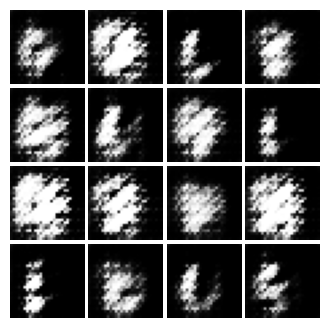

반복(Epoch): 33, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 34 is 10.13151216506958 sec


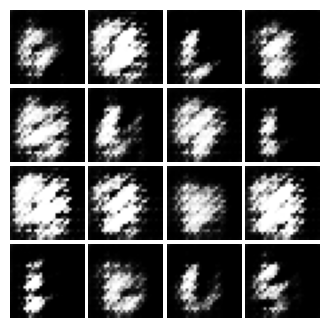

반복(Epoch): 34, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 35 is 10.065405130386353 sec


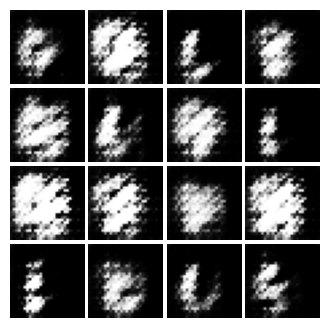

반복(Epoch): 35, Generator 손실함수(g_loss): 1.313259, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 36 is 10.063068866729736 sec


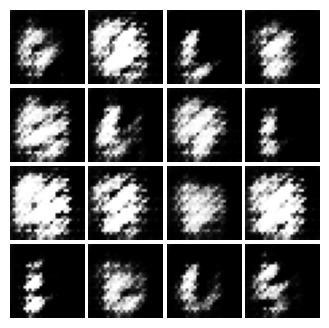

반복(Epoch): 36, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 37 is 10.03548812866211 sec


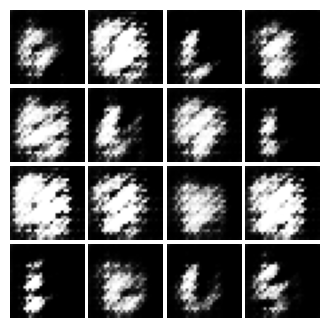

반복(Epoch): 37, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 38 is 10.047219276428223 sec


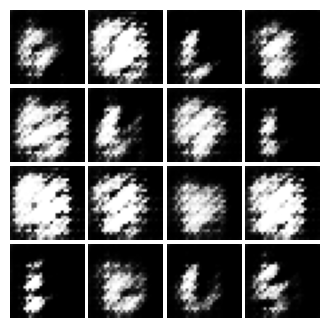

반복(Epoch): 38, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 39 is 10.025258541107178 sec


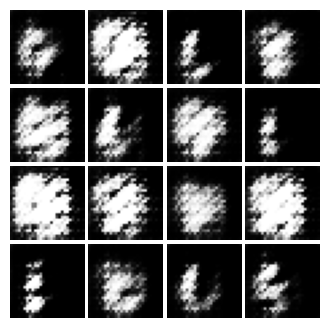

반복(Epoch): 39, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 40 is 10.015099287033081 sec


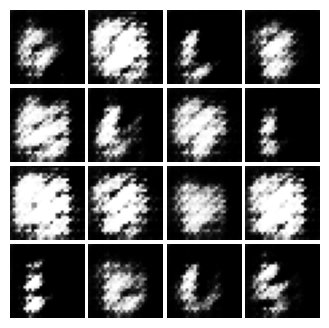

반복(Epoch): 40, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 41 is 10.003374576568604 sec


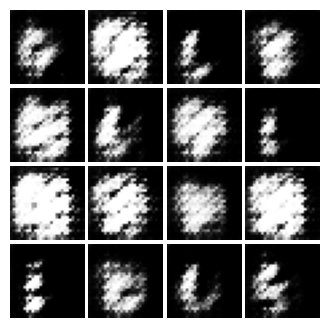

반복(Epoch): 41, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 42 is 9.98836088180542 sec


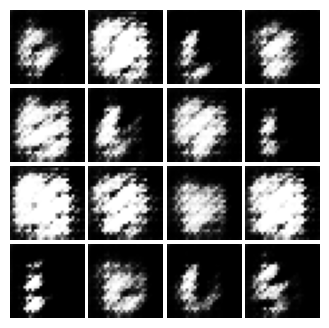

반복(Epoch): 42, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 43 is 9.963356971740723 sec


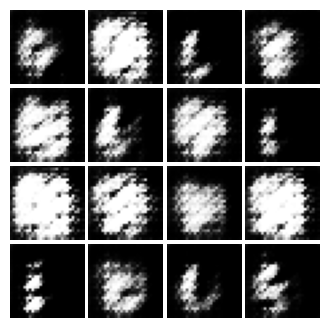

반복(Epoch): 43, Generator 손실함수(g_loss): 1.313261, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 44 is 9.955061435699463 sec


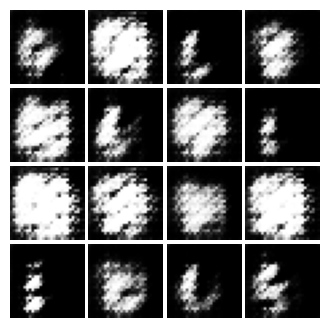

반복(Epoch): 44, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 45 is 9.974709749221802 sec


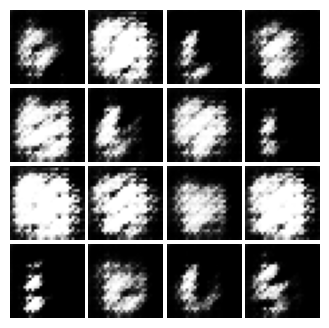

반복(Epoch): 45, Generator 손실함수(g_loss): 1.313261, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 46 is 9.981412649154663 sec


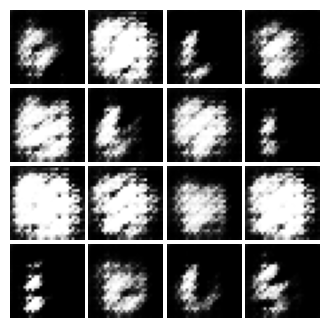

반복(Epoch): 46, Generator 손실함수(g_loss): 1.313260, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 47 is 10.22330904006958 sec


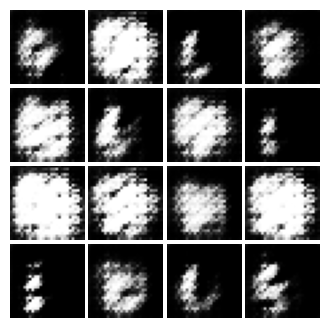

반복(Epoch): 47, Generator 손실함수(g_loss): 1.313261, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 48 is 9.966954946517944 sec


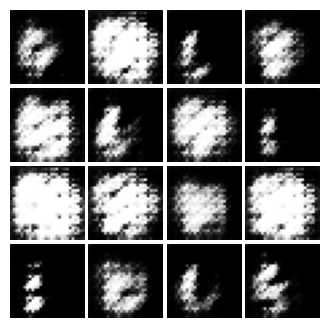

반복(Epoch): 48, Generator 손실함수(g_loss): 1.313261, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 49 is 9.978431463241577 sec


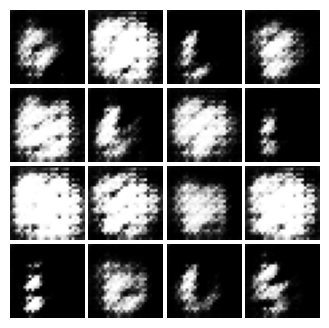

반복(Epoch): 49, Generator 손실함수(g_loss): 1.313261, Discriminator 손실함수(d_loss): 1.626524
Time for epoch 50 is 9.947892665863037 sec


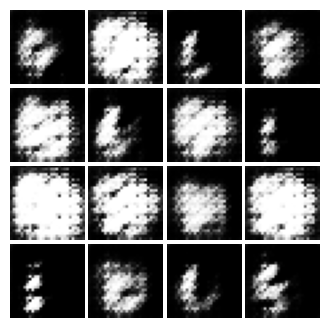

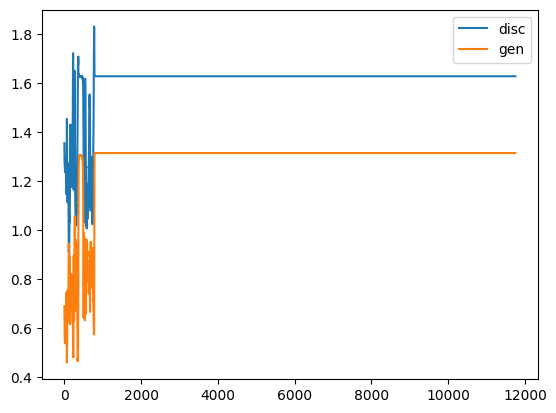

CPU times: user 2min 49s, sys: 22.5 s, total: 3min 11s
Wall time: 9min 13s


In [339]:
%%time
train(train_dataset, 50)

## 4. application

In [247]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [248]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [249]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-249-767a4c587277>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-249-767a4c587277>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [250]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>